In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
from scipy import signal, stats, io
import numpy as np
import sys
sys.path.append('..')
import glob
from neurolib.utils import functions
from neurolib.models.wc import WCModel
import neurolib.utils.loadData as ld
import neurolib.utils.functions as func
from task_fc_simulation.read_utils import read_onsets_from_input, read_generate_task_matrices
from task_fc_simulation.onset_design_model import WCOnsetDesign, HRF
from task_fc_simulation.cole2019model import NeuralMassModel
from task_fc_simulation.weight_matrix_utils import normalize, generate_modulars
%load_ext autoreload
%autoreload 2
plt.rcParams['image.cmap'] = 'plasma'

## WC model with one neuron

In [2]:
wc = WCModel()
wc.params['duration'] = 2.0*1000

In [3]:
max_exc = []
min_exc = []
# these are the different input values that we want to scan
exc_inputs = np.linspace(0, 3.5, 50)
for exc_ext in exc_inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    wc.params['exc_ext'] = exc_ext
    wc.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_exc.append(np.max(wc.exc[0, -int(1000/wc.params['dt']):]))
    min_exc.append(np.min(wc.exc[0, -int(1000/wc.params['dt']):]))

Text(0, 0.5, 'Min / max exc')

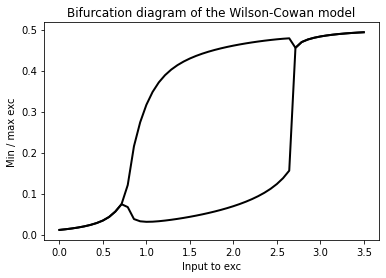

In [4]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")

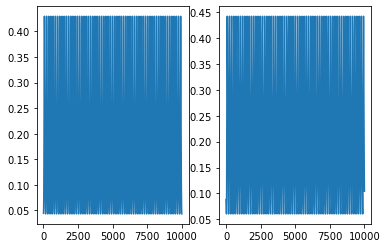

In [5]:
exc_ext = 1.5
wc.params['exc_ext'] = exc_ext
wc.run()
plt.subplot(1,2,1); plt.plot(wc.exc[0, -int(1000/wc.params['dt']):]);
plt.subplot(1,2,2);plt.plot(wc.inh[0, -int(1000/wc.params['dt']):]);

## WC model with our setting and zero noise

and predefined matrix

In [6]:
wc_params = {'exc_ext': 0.76, # baseline external input to E
             'K_gl': 2.72, # global coupling strength
             'sigma_ou': 0, # noise intensity
             'inh_ext': 0, # baseline external input to I
             'tau_ou': 5, # ms Timescale of the Ornstein-Uhlenbeck noise process
             'a_exc': 1.5, # excitatory gain
             'a_inh': 1.5, # inhibitory gain
             'c_excexc': 16, #local E-E coupling
             'c_excinh': 15, # local E-I coupling
             'c_inhexc': 12, # local I-E coupling
             'c_inhinh': 3, # local I-I coupling
             'mu_exc': 3,  # excitatory firing threshold
             'mu_inh': 3,  # inhibitory firing threshold
             'tau_exc': 2.5, # excitatory time constant
             'tau_inh': 3.75, # inhibitory time constant
             'signalV': 10 # signal transmission speed between areas
            }
sim_parameters = {"delay": 250,"rest_before":True, "first_duration": 6, "last_duration": 6}
TR = 2
a_s_rate = 5*1e-3 #sampling in s, original integration equal to 0.1 ms or 0.0001s
activity = False
#see notebook HRFConvolution for parameters description
bw_params = {"rho": 0.34, "alpha": 0.32, "V0": 0.02, "k1_mul": None,
                     "k2": None, "k3_mul": None, "gamma": None, "k": None, "tau":None}

In [7]:
SMALL = True
mat_path = '../data/01_BLOCK.mat'
input_data = io.loadmat(mat_path)
if SMALL:
    small_input_data = input_data.copy()
    small_input_data['onsets'][0,0] = input_data['onsets'][0,0][:2]
    small_input_data['onsets'][0,1] = input_data['onsets'][0,1][:2]
    small_mat_path = os.path.join(os.path.dirname(mat_path),'small_'+os.path.basename(mat_path))
    io.savemat(small_mat_path, small_input_data)
    mat_path = small_mat_path
print(f"In the simulation {os.path.basename(mat_path)} will be used")  

In the simulation small_01_BLOCK.mat will be used


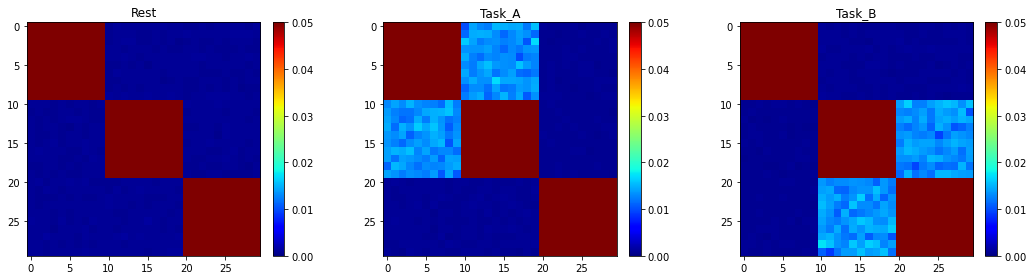

In [8]:
N_ROIs = 30
#generate matrices with the coefficients, which we defined in "task_matrices" and "rest_matrices" fields of the mat file
C_rest, C_task_dict = read_generate_task_matrices(mat_path, N_ROIs, num_modules=3,
                                sigma=0.1, norm_type="cols")
C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['Rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))

#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(C_list[i], cmap='jet', vmin = 0, vmax=0.05); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [9]:
%%time
#path to mat file with the predefined structure with onsets and synaptic weights matrices parameters
wc_block = WCOnsetDesign.from_matlab_structure(mat_path, num_regions= N_ROIs, **wc_params, **sim_parameters)
wc_block.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, clear_exc = False, **bw_params)

CPU times: user 9.96 s, sys: 256 ms, total: 10.2 s
Wall time: 10.2 s


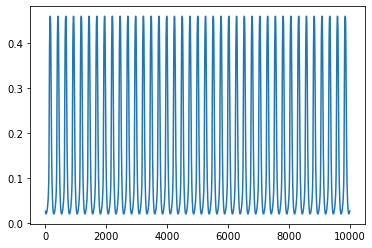

In [10]:
plt.plot(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]);

In [11]:
max_exc = []
min_exc = []
# these are the different input values that we want to scan
exc_inputs = np.linspace(0, 3.5, 30)
for exc_ext in tqdm(exc_inputs):
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    wc_params['exc_ext'] = exc_ext
    wc_block = WCOnsetDesign.from_matlab_structure(mat_path, num_regions= N_ROIs, **wc_params, **sim_parameters)
    wc_block.generate_full_series(TR=TR, activity=activity, a_s_rate=a_s_rate, clear_exc = False, **bw_params)
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_exc.append(np.max(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]))
    min_exc.append(np.min(wc_block.wc.exc[0, -int(1000/wc.params['dt']):]))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:43<00:00,  9.44s/it]


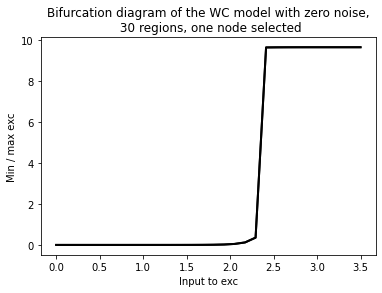

In [22]:
plt.plot(exc_inputs, max_exc, c='k', lw = 2)
plt.plot(exc_inputs, min_exc, c='k', lw = 2)
plt.title(f"Bifurcation diagram of the WC model with zero noise,\n {N_ROIs} regions, one node selected")
plt.xlabel("Input to exc");
plt.ylabel("Min / max exc");
bif_dict = {"wc": np.array([exc_inputs, max_exc, min_exc])}

## Cole (2019) model replication

$$\tau_{E} \dot{E_i} = - E_i + f_{E}(c_{EE}*E_i+K_{gl}\sum_{j\neq i} C_{ij}E_{j}+PE_i) + OU_{i}$$

Implicit difference first order vscheme 

$$\tau_{E} \dot{E_i}  = \tau_{E}\frac{E_i(t+1)-E_i(t)}{dt} = -E_i(t)+\ldots$$

if $\tau_{E}/{dt}=1$, $E_i(t+1)-E_i(t) = -E_i(t)+\ldots$
$$E_i(t+1) = f_{E}(K_{gl}\sum_j C_{ij}E_{j}+PE_i) + OU_{i}$$

For Cole:

 - $I_i(t) = \sum_jGw_{ij}u_j(t-1)+d_i+stim$
 - $u_i(t)=f(I_i+bias)$
 
 $$I_i(t) = \sum_jGw_{ij}f(I_j(t-1)+bias)+d_i+stim$$

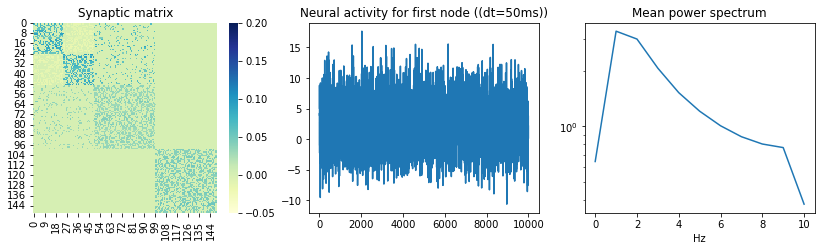

In [13]:
nms = NeuralMassModel(150, num_modules=3)
nms._init_synpatic_cole()
# we took from original code: https://github.com/ColeLab/TaskFCRemoveMeanActivity/blob/master/neuralmassmodel/NeuralMassModel.ipynb
bias_param = -5
indep = 5
g = 5
spont_act_level = 3
output = nms.compute_network_model_cole(10000, bias_param=bias_param,
                                                spont_act_level=spont_act_level, g=g, indep=indep)
fig, axs = plt.subplots(1,3,figsize=(14, 3.5))

sns.heatmap(nms.synaptic_weight, annot=False, vmin=-0.05, vmax=0.2, ax=axs[0], cmap="YlGnBu")
axs[0].set_title("Synaptic matrix")
axs[1].plot(output['input_activity'][:,0])
axs[1].set_title('Neural activity for first node ((dt=50ms))');
maxfr = 50
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(output['input_activity'].T, 50, spectrum_windowsize=1, maxfr=maxfr)
axs[2].semilogy(f,  Pxx_Welsh); axs[2].set_title('Mean power spectrum', fontsize=12);
axs[2].set_xlabel("Hz");

In [14]:
results_dict = {"syn_matrix": nms.synaptic_weight, "act": output['input_activity'][:,0], "PowerDensity": np.array([f, Pxx_Welsh]), }
#io.savemat(resmatfile, {**results_dict, **setting_dict})

## Bifurcation diagram for Cole with zero noise and changing bias

In [15]:
#output['input_activity'][-1000:,0]

In [16]:
max_exc = []
min_exc = []
# these are the different input values that we want to scan
bias_params = np.linspace(-20, 5, 30)
indep = 5
g = 5
spont_act_level = 0
for bias_param in tqdm(bias_params):
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    output = nms.compute_network_model_cole(10000, bias_param=bias_param,
                                                spont_act_level=spont_act_level, g=g, indep=indep)
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_exc.append(np.max(output['input_activity'][-1000:,0]))
    min_exc.append(np.min(output['input_activity'][-1000:,0]))
bif_dict["Cole"] = np.array([bias_params, max_exc, min_exc])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.00it/s]


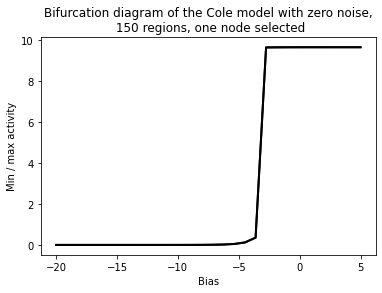

In [21]:
plt.plot(bias_params, max_exc, c='k', lw = 2)
plt.plot(bias_params, min_exc, c='k', lw = 2)
plt.title(f"Bifurcation diagram of the Cole model with zero noise,\n 150 regions, one node selected")
plt.xlabel("Bias");
plt.ylabel("Min / max activity");

In [18]:
resmatfile = '../data/ResultBifsCole.mat'
io.savemat(resmatfile, {**bif_dict, **results_dict})

In [20]:
io.loadmat('../data/ResultBifsCole.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Nov  8 20:20:05 2022',
 '__version__': '1.0',
 '__globals__': [],
 'Cole': array([[-2.00000000e+01, -1.91379310e+01, -1.82758621e+01,
         -1.74137931e+01, -1.65517241e+01, -1.56896552e+01,
         -1.48275862e+01, -1.39655172e+01, -1.31034483e+01,
         -1.22413793e+01, -1.13793103e+01, -1.05172414e+01,
         -9.65517241e+00, -8.79310345e+00, -7.93103448e+00,
         -7.06896552e+00, -6.20689655e+00, -5.34482759e+00,
         -4.48275862e+00, -3.62068966e+00, -2.75862069e+00,
         -1.89655172e+00, -1.03448276e+00, -1.72413793e-01,
          6.89655172e-01,  1.55172414e+00,  2.41379310e+00,
          3.27586207e+00,  4.13793103e+00,  5.00000000e+00],
        [ 1.99243272e-08,  4.71819050e-08,  1.11729355e-07,
          2.64581300e-07,  6.26543288e-07,  1.48369014e-06,
          3.51346634e-06,  8.32011764e-06,  1.97026980e-05,
          4.66582031e-05,  1.10495528e-04,  2.61695026e-04,
          6.199